In [ ]:
!pip install torch torchvision tqdm matplotlib requests

In [ ]:
import torch
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
import requests
import os
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as dataloaders
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
# !pip install rarfile

# import os
# import rarfile

# # Create dataset directory first
# dataset_folder = './dataset'
# os.makedirs(dataset_folder, exist_ok=True)
# print(f"✓ Created dataset folder: {dataset_folder}")

# # Download the RAR file (using a clean output filename)
# rar_filename = "images.rar"
# download_url = "https://chaladze.com/l5/img/Linnaeus%205%20128X128.rar"

# print(f"Downloading {rar_filename}...")
# !wget -O {rar_filename} "{download_url}"

# # Extract contents
# rar_path = rar_filename
# if os.path.exists(rar_path):
#     try:
#         rf = rarfile.RarFile(rar_path)
#         rf.extractall(dataset_folder)
#         print(f"✓ Extraction complete! Files extracted to {dataset_folder}")

#         # Verify extraction and show first few files
#         print("\nExtracted files:")
#         extracted_files = []
#         for root, dirs, files in os.walk(dataset_folder):
#             for file in files[:10]:  # Show first 10 files as sample
#                 print(f"  {os.path.join(root, file)}")
#     except Exception as e:
#         print(f"✗ Extraction error: {e}")
# else:
#     print(f"✗ Error: RAR file not found at {rar_path}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
models_dump = '/content/drive/MyDrive/Colab Notebooks/models/stable_diffusion_training'
dataset_path = '/content/drive/MyDrive/Colab Notebooks/dataset/stable_diffusion_training/images/train/dog'

In [ ]:
# !pip install rarfile

# import rarfile

# # Download
# !wget "https://chaladze.com/l5/img/Linnaeus%205%20128X128.rar"

# # Extract
# rar_path = 'images.rar'
# if os.path.exists(rar_path):
#     rf = rarfile.RarFile(rar_path)
#     rf.extractall('./dataset')
#     print("✓ Extraction complete!")

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class DogDataset(Dataset):
    def __init__(self, path, transform=None, max_length=None):
        self.path = path
        self.transform = transform
        self.images = sorted(os.listdir(path))
        if max_length is not None:
            self.images = self.images[:max_length]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.path, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


In [ ]:
def data_loader(path, max_length=None):
    print("Data loader Started")
    data_sets = DogDataset(path, transform=transforms.ToTensor(), max_length=max_length)
    # if max_length is not None:
    #     data_sets = torch.utils.data.Subset(data_sets, range(max_length))
    data_loader = dataloaders.DataLoader(data_sets, batch_size=32, shuffle=True)
    return data_loader

In [ ]:
import torch
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
import requests
import os
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as dataloaders
import torch.optim as optim
import torch.nn.functional as F

# VAE
# Variavtional Auto Endcoder
class VAE(nn.Module):
    def __init__(self,in_channels=3, image_size=32, blocks=2):
        super().__init__()
        self.encoder = VAEEncoder(
            in_channels=in_channels,
            latent_dim=(image_size / (2 ** blocks)),
            block_count=blocks
        )

        print(f"In vae channels out : {self.encoder.out_channels}")

        latent_channels = self.encoder.out_channels

        self.mean = nn.Conv2d(in_channels=latent_channels, out_channels=latent_channels, kernel_size=4, padding=1)
        self.log_variance = nn.Conv2d(in_channels=latent_channels, out_channels=latent_channels, kernel_size=4, padding=1) # Renamed to log_variance

        self.decoder = VAEDecoder(
            in_channels=latent_channels, out_channels=3, blocks=blocks
        )

    def get_out_channels(self):
        return self.encoder.out_channels

    def reparameterized_trick(self, mean, log_variance):
        std = torch.exp(0.5 * log_variance) # Standard deviation
        epsilon = torch.randn_like(std)
        z = mean + std * epsilon
        return z

    def encode(self, image_tensor):
        latent = self.encoder(image_tensor)

        mean = self.mean(latent)
        log_variance = self.log_variance(latent) # Get log_variance

        z = self.reparameterized_trick(mean=mean, log_variance=log_variance)

        return latent, z, mean, log_variance # Return log_variance

    def decode(self, latent):
        x = self.decoder(latent)
        return x


class VAEEncoder(nn.Module):
    def __init__(self, in_channels, latent_dim, block_count=2):
        super().__init__()
        self.blocks = nn.ModuleList()
        curr_channels = in_channels
        for i in range(block_count):
            out_channel = 64 * (2 ** i)
            self.blocks.append(
                self.conv_block(
                    in_channels=curr_channels,
                    out_channel=out_channel,
                )
            )
            curr_channels = out_channel

        self.out_channels = out_channel

    def conv_block(self, in_channels, out_channel):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channel,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )

    def forward(self, image_tensor):
        latent = image_tensor
        for block in self.blocks:
            latent = block(latent)
        return latent


class VAEDecoder(nn.Module):
    def __init__(self, in_channels=128, out_channels=3, blocks=2):
        super().__init__()
        self.blocks = nn.ModuleList()
        self.in_channels = in_channels
        self.out_channels = out_channels
        curr_channels = in_channels
        for i in range(blocks):
            next_channels = 3 if i == (blocks - 1) else in_channels // 2
            self.blocks.append(
                self.conv_block(
                    in_channels=curr_channels,
                    out_channel=next_channels
                )
            )
            curr_channels = next_channels

    def conv_block(self, in_channels, out_channel):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channel,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.ReLU(),
        )

    def forward(self, latent):
        x = latent
        for block in self.blocks:
            x = block(x)
        return x


class VAELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        input, output, mean, log_variance = x # Expect log_variance directly
        reconstruction_loss = torch.mean((input - output) ** 2)
        kl_loss = -0.5 * torch.sum(1 + log_variance - mean ** 2 - torch.exp(log_variance))
        beta = 0.001
        total_loss = reconstruction_loss + beta * kl_loss
        return total_loss, reconstruction_loss, kl_loss

In [ ]:
# Train VAE
train_losses = []
recon_losses = []
kl_losses = []



def train_vae(config=None):
    print("Training VAE...")
    dataloader = data_loader(dataset_path, max_length=200)
    vae = VAE(in_channels=3, image_size=128, blocks=2)
    vae_loss = VAELoss()
    optimizer = optim.Adam(vae.parameters(), lr=0.001)
    epochs = 50

    for epoch in tqdm(range(epochs)):
      epochs_total_loss = 0.0
      epochs_recon_loss = 0.0
      epochs_kl_loss = 0.0

      for batch_idx, data in enumerate(dataloader):
          # print(f"Epoch: {epoch}, Batch: {batch_idx} shape :{data.shape}")
          latent, z, z_mean, z_log_variance = vae.encode(data)  # Get z_log_variance directly
          output = vae.decode(latent=latent)
          loss, recon_loss, kl_loss = vae_loss([data, output, z_mean, z_log_variance]) # Pass z_log_variance
          # print(f"log_variance: {z_log_variance.shape} mean {z_mean.shape}")
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          epochs_total_loss += loss.item()
          epochs_recon_loss += recon_loss.item()
          epochs_kl_loss += kl_loss.item()

      avg_loss = epochs_total_loss / len(dataloader)
      avg_recon = epochs_recon_loss / len(dataloader)
      avg_kl = epochs_kl_loss / len(dataloader)

      train_losses.append(avg_loss)
      recon_losses.append(avg_recon)
      kl_losses.append(avg_kl)

    print("VAE training completed.")
    dump_path = models_dump + "/vae_model.pth"
    torch.save(vae.state_dict(), dump_path)
    print(f"VAE model saved to {dump_path}")

    # Save losses for later use
    torch.save(
        {
            'train_losses': train_losses,
            'recon_losses': recon_losses,
            'kl_losses': kl_losses
        }, 'loss_history.pt'
    )

# train_vae()
print(f"loss {train_losses} recon {recon_losses} kl loss {kl_losses}")

loss [] recon [] kl loss []


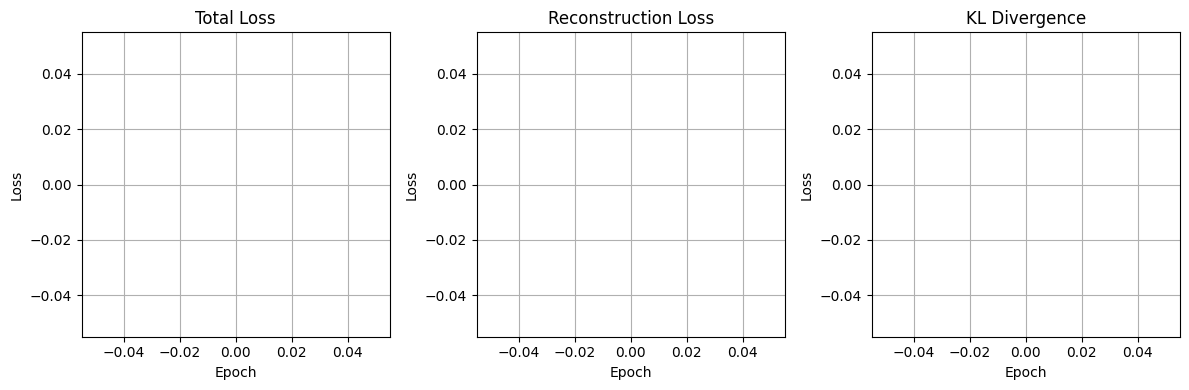

In [ ]:
# PLOT vae training loss

def plot_loss_curves():
    plt.figure(figsize=(12, 4))

    # Subplot 1: Total Loss
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Total Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Subplot 2: Reconstruction Loss
    plt.subplot(1, 3, 2)
    plt.plot(recon_losses, label='Reconstruction Loss', color='orange')
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Subplot 3: KL Divergence
    plt.subplot(1, 3, 3)
    plt.plot(kl_losses, label='KL Divergence', color='green')
    plt.title('KL Divergence')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('vae_loss_curves.png', dpi=300)
    plt.show()

# Call after training
plot_loss_curves()

In [ ]:
# Train stable diffusion model

# Unet
class UNet(nn.Module):
    def __init__(self, in_channels, blocks=2):
        super().__init__()
        self.in_channels = in_channels
        self.blocks = blocks

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        curr_channels = in_channels
        # Encoder
        for i in range(blocks):
            next_channels = curr_channels * 2
            self.encoder.append(EncoderBlock(curr_channels, next_channels))

            curr_channels = next_channels

        # Bottleneck means convoltional layer without `max pooling`
        self.bottleneck = EncoderBlock(curr_channels, curr_channels)

        # Decoder
        for i in range(blocks):
            next_channels = curr_channels // 2
            self.decoder.append(DecoderBlock(curr_channels, next_channels))

            curr_channels = next_channels

    def sinusoidal_embedding(self, time_step, embedding_dim):
      device = time_step.device
      dtype = time_step.dtype
      half_dim = embedding_dim // 2
      emb = torch.log(torch.tensor(10000.0, device=device, dtype=dtype)) / (half_dim - 1)
      emb = torch.exp(torch.arange(half_dim, device=device, dtype=dtype) * -emb)
      emb = time_step[:, None] * emb[None, :]
      emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=1)
      return emb


    def forward(self, z_t, time_step):
      x = z_t
      skip_connections = []
      for enc in self.encoder:
        x, s_c = enc(x)
        skip_connections.append(s_c)

      pos_encoding = self.sinusoidal_embedding(time_step, x.size(1))
      # Explicitly expand pos_encoding to match spatial dimensions of x before addition
      # pos_encoding shape is (batch_size, channels)
      # x shape is (batch_size, channels, H, W)
      # Unsqueeze twice to get (batch_size, channels, 1, 1), then expand
      pos_encoding_expanded = pos_encoding.unsqueeze(-1).unsqueeze(-1).expand_as(x)
      x = x + pos_encoding_expanded

      x, _ = self.bottleneck(x, is_bottleneck=True)


      for dec in self.decoder:
        x = dec(x, skip_connections.pop())

      return x # This is predicted epsilon


class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encode = self.conv_block(in_channels=in_channels, out_channel=out_channels)
        self.max_pooling = nn.MaxPool2d(kernel_size=2, stride=2) # Changed kernel and stride

    def conv_block(self, in_channels, out_channel):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channel,
                kernel_size=3, # Changed kernel_size from 4 to 3
                stride=1,      # Changed stride from 2 to 1
                padding=1      # Added padding
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_channel,
                out_channels=out_channel,
                kernel_size=3, # Changed kernel_size from 4 to 3
                stride=1,      # Changed stride from 2 to 1
                padding=1      # Added padding
            ),
            nn.ReLU()
        )

    def forward(self, x, is_bottleneck=False):
        x = self.encode(x)
        if is_bottleneck:
            return x, None # Bottleneck doesn't produce skip for itself
        else:
            skip = x
            x = self.max_pooling(x)
            return x, skip


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.decode = self.conv_block(in_channels=out_channels + in_channels, out_channel=out_channels) # Corrected in_channels for decode

    def conv_block(self, in_channels, out_channel):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channel,
                kernel_size=3, # Changed kernel_size from 4 to 3
                stride=1,      # Changed stride from 2 to 1
                padding=1      # Added padding
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_channel,
                out_channels=out_channel,
                kernel_size=3, # Changed kernel_size from 4 to 3
                stride=1,      # Changed stride from 2 to 1
                padding=1      # Added padding
            ),
            nn.ReLU()
        )

    def forward(self, x, skip_connection):
        x = self.up(x)
        # Handle potential size mismatch due to ConvTranspose2d
        target_h, target_w = skip_connection.size(2), skip_connection.size(3)
        if x.size(2) != target_h or x.size(3) != target_w:
            diff_h = target_h - x.size(2)
            diff_w = target_w - x.size(3)

            # Apply padding or cropping
            if diff_h > 0 or diff_w > 0:
                x = F.pad(x, [diff_w // 2, diff_w - diff_w // 2,
                              diff_h // 2, diff_h - diff_h // 2])
            elif diff_h < 0 or diff_w < 0:
                x = x[:, :, :target_h, :target_w]

        x = torch.cat([x, skip_connection], dim=1)
        x = self.decode(x)
        return x

In [ ]:
# Train the model

# forward process is used to predict the noisy latent for the given timestamp
def forward_process(z_0, time_step, epsilon=None, max_timestamp=1000):
    # Define beta schedule (linear from 0.0001 to 0.02)
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(beta_start, beta_end, max_timestamp, device=z_0.device)

    # Calculate alpha and cumulative product of alphas (alpha_bar)
    alphas = 1.0 - betas
    # alphas_cumprod[t] is the product of (1 - beta_s) from s=1 to t
    alphas_cumprod = torch.cumprod(alphas, dim=0)

    # Get alpha_bar_t for each time_step in the batch
    # time_step is a tensor of shape (batch_size,) with values from 1 to MAX_TIMESTAMP
    # We use time_step - 1 for 0-indexed access to alphas_cumprod
    alpha_bar_t_batch = alphas_cumprod[time_step - 1]

    # Reshape alpha_bar_t_batch to be broadcastable with z_0 and epsilon
    # e.g., (batch_size,) -> (batch_size, 1, 1, 1) for image tensors
    alpha_bar_t_batch = alpha_bar_t_batch.view(-1, 1, 1, 1)

    # Apply the diffusion formula: z_t = sqrt(alpha_bar_t) * z_0 + sqrt(1 - alpha_bar_t) * epsilon
    z_t = torch.sqrt(alpha_bar_t_batch) * z_0 + torch.sqrt(1 - alpha_bar_t_batch) * epsilon
    return z_t


# Training process for unet
def train_model():
    print("Training started...")
    dataloader = data_loader(dataset_path, max_length=100) # Using max_length=10 for quicker testing
    # when we are trying to train unet , unet input will be 28x28 or latent size?
    # it is latent

    vae = VAE(in_channels=3, image_size=128, blocks=2) # Changed blocks from 1 to 2
    vae.load_state_dict(torch.load(models_dump + "/vae_model.pth"))
    out_channels = vae.get_out_channels()
    unet = UNet(in_channels=out_channels)
    MAX_TIMESTAMP = 200
    epochs = 5 # Reduced epochs for quicker testing

    optimizer = optim.Adam(unet.parameters(), lr=0.001)
    train_losses = []

    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}")
        for batch_idx, data in enumerate(dataloader):
            t = torch.randint(1, MAX_TIMESTAMP, (data.size(0),), device=data.device).long()

            # Ensure VAE is in eval mode during UNet training to prevent VAE weights from changing
            vae.eval()
            with torch.no_grad(): # No need to calculate gradients for VAE during UNet training
              latent, z, mean, log_variance = vae.encode(data)  # Get the VAE latent

            # add some noise here
            epsilon = torch.randn_like(z)
            # Pass MAX_TIMESTAMP to forward_process
            noisy_z_t = forward_process(z_0=z, time_step=t, epsilon=epsilon, max_timestamp=MAX_TIMESTAMP)

            pred_epsiloin = unet(noisy_z_t, t)
            loss = torch.mean((pred_epsiloin - epsilon) ** 2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

    print("Diffusion Training completed.")
    dump_path = models_dump + "/diffusion_model.pth"
    # Note: Saving VAE state dict here, likely intended to save UNet's state dict
    torch.save(unet.state_dict(), dump_path)
    print(f"Diffusion model saved to {dump_path}")

    # Save losses for later use
    torch.save(
        {
          'train_losses': train_losses
        }, 'diffusion_loss_history.pt'
    )


def plot_loss_curves():
    plt.figure(figsize=(12, 4))

    # Subplot 1: Total Loss
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Total Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)


# train_model()

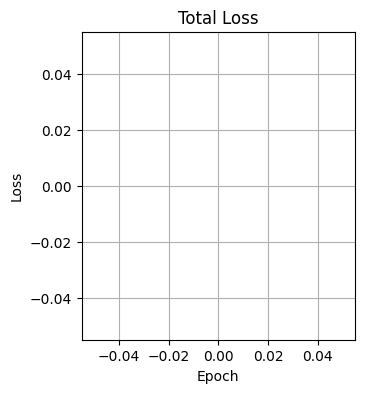

In [ ]:
plot_loss_curves()

In [ ]:
import torch
import matplotlib.pyplot as plt

# Inference generation

def normalize_image_tensor(image_tensor):
    # Ensure the tensor is on CPU and convert to numpy
    image_np = image_tensor.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()
    # Normalize to [0, 1]
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min() + 1e-8) # Add epsilon to avoid division by zero
    return image_np

def generate_image(unet, vae, config=None):
    print("Inference started...")

    MAX_TIMESTAMP = 1000 # Changed to 1000 to match training

    # vae = VAE(image_size=128, blocks=2)
    vae.load_state_dict(torch.load(models_dump + "/vae_model.pth"))
    vae.eval() # Set VAE to evaluation mode
    out_channels = vae.get_out_channels()

    # unet = UNet(in_channels=out_channels)
    unet.load_state_dict(torch.load(models_dump + "/diffusion_model.pth"))
    unet.eval() # Set UNet to evaluation mode

    # Initialize z_t as pure noise in the latent space
    # The latent z has shape (batch_size, out_channels, 32, 32) for image_size=128, blocks=2
    # Use the device of the vae parameters
    device = vae.parameters().__next__().device
    z_t = torch.randn((1, out_channels, 32, 32), device=device)

    with torch.no_grad():
      for t in tqdm(range(MAX_TIMESTAMP - 1, 0, -1)):
          # Pass 'z_t' (the noisy latent) to UNet, consistent with training
          predict_epsilon = unet(z_t, torch.tensor([t], device=z_t.device))
          z_t = reverse_process_noisy_latent(z_t, t, predict_epsilon, MAX_TIMESTAMP=MAX_TIMESTAMP)

    print("Inference completed.")
    # Decode the final latent representation
    return vae.decode(z_t)

def reverse_process_noisy_latent(z_t, t, ep, MAX_TIMESTAMP):
    # Define beta schedule (linear from 0.0001 to 0.02) - Changed beta_start to match forward_process
    beta_start = 0.0001
    beta_end = 0.02
    EPS = 1e-8
    # Ensure b_t is created for all required timesteps up to MAX_TIMESTAMP
    b_t = torch.linspace(beta_start, beta_end, MAX_TIMESTAMP, device=z_t.device)
    alpha_t = 1. - b_t
    product_beta_t = torch.cumprod(alpha_t, dim=0)

    # Select the correct beta and alpha_cumprod for the current timestep t
    beta_t_scalar = b_t[t-1] # Adjust for 0-indexing
    alpha_t_scalar = alpha_t[t-1]
    product_beta_t_scalar = product_beta_t[t-1]

    # Apply the reverse diffusion formula
    z_t_minus_1 = 1 / torch.sqrt(alpha_t_scalar).clamp(EPS) * (z_t - (beta_t_scalar / torch.sqrt(1 - product_beta_t_scalar).clamp(EPS)) * ep)
    # Add noise only if t > 1
    if t > 1:
        z_t_minus_1 = z_t_minus_1 + torch.sqrt(beta_t_scalar).clamp(EPS) * torch.randn_like(z_t)

    return z_t_minus_1

vae = VAE(image_size=128, blocks=2)
out_channels = vae.get_out_channels()
unet = UNet(in_channels=out_channels)
# decoded = generate_image(vae=vae, unet=unet)
# image_np = normalize_image_tensor(decoded)
# plt.imshow(image_np)
# plt.show()

In vae channels out : 128


In [ ]:
# convert model for mobile - LiteRT

# Uninstall potentially conflicting packages first
!pip uninstall -y tensorflow ai-edge-tensorflow ai-edge-torch

!pip install ai-edge-torch

Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: ai_edge_tensorflow 2.21.0.dev20251110
Uninstalling ai_edge_tensorflow-2.21.0.dev20251110:
  Successfully uninstalled ai_edge_tensorflow-2.21.0.dev20251110
Found existing installation: ai-edge-torch 0.7.1
Uninstalling ai-edge-torch-0.7.1:
  Successfully uninstalled ai-edge-torch-0.7.1
  Using cached ai_edge_torch-0.7.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached ai_edge_tensorflow-2.21.0.dev20251110-cp312-cp312-manylinux_2_27_x86_64.whl.metadata (4.6 kB)
Using cached ai_edge_torch-0.7.1-py3-none-any.whl (457 kB)
Using cached ai_edge_tensorflow-2.21.0.dev20251110-cp312-cp312-manylinux_2_27_x86_64.whl (268.5 MB)


In [ ]:
import ai_edge_torch
import torch.fx # Added import for symbolic tracing
import ai_edge_torch.quantize.pt2e_quantizer as pt2e_quantizer # Corrected import
from ai_edge_torch.quantize import quant_config
from torch.ao.quantization.quantize_pt2e import prepare_pt2e, convert_pt2e # Explicitly import prepare_pt2e and convert_pt2e
import torch.export # Import torch.export


class DiffusionUnetWrapper(nn.Module):
  def __init__(self, unet) -> None:
    super().__init__()
    self.unet = unet

  def forward(self, x, time_step): # Corrected signature to accept time_step
    if time_step.dim() == 1:
          time_step = time_step.view(-1)

    return self.unet(x, time_step)


class VAEEncoderWrapper(nn.Module):
  def __init__(self, vae) -> None:
    super().__init__()
    self.vae = vae

  def forward(self, x):
    # During quantization and compilation, torch.randn_like might cause issues.
    # For TFLite conversion, we return the deterministic mean of the latent space.
    latent = self.vae.encoder(x)
    mean = self.vae.mean(latent)
    # The log_variance and reparameterization trick are omitted here for deterministic conversion.
    return mean # Return mean instead of z for TFLite conversion


class VAEDecoderWrapper(nn.Module):
  def __init__(self, vae) -> None:
    super().__init__()
    self.vae = vae

  def forward(self, x):
    return self.vae.decode(x)


def convert_to_tflite(
    model: nn.Module,
    sample_input, # Can be a single Tensor or a tuple of Tensors
    output_path: str,
    quantize: bool = True
):
    # Set model to eval mode
    model.eval()

    # edge_model = ai_edge_torch.convert(
    #   model,
    #   sample_input,
    # )
    # path = output_path + "fp32.tflite"

    # edge_model.save(
    #     os.path.join(models_dump, path)
    # )

    if isinstance(sample_input, torch.Tensor):
        sample_input = (sample_input,)
    elif isinstance(sample_input, list):
        sample_input = tuple(sample_input)
    elif not isinstance(sample_input, tuple):
        raise ValueError(f"sample_input must be Tensor, list, or tuple. Got {type(sample_input)}")

    if quantize:
        quantizer = pt2e_quantizer.PT2EQuantizer().set_global(
            pt2e_quantizer.get_symmetric_quantization_config()
        )

        edge_model = ai_edge_torch.convert(
            model,
            sample_input,
            quant_config=quant_config.QuantConfig(pt2e_quantizer=quantizer),
        )
    else:
        edge_model = ai_edge_torch.convert(model, sample_input)

    # Save to file
    edge_model.export(output_path)
    print(f"✓ Model saved to {output_path}")

    # Print file size
    import os
    size_mb = os.path.getsize(output_path) / (1024 * 1024)
    print(f"✓ Model size: {size_mb:.2f} MB")

NotFoundError: /usr/local/lib/python3.12/dist-packages/tensorflow/core/kernels/libtfkernel_sobol_op.so: undefined symbol: _ZN10tensorflow15TensorShapeBaseINS_11TensorShapeEEC2EN4absl12lts_202308024SpanIKlEE

In [ ]:
import ai_edge_torch
import torch.fx # Added import for symbolic tracing
import ai_edge_torch.quantize.pt2e_quantizer as pt2e_quantizer # Corrected import
from ai_edge_torch.quantize import quant_config
from torch.ao.quantization.quantize_pt2e import prepare_pt2e, convert_pt2e # Explicitly import prepare_pt2e and convert_pt2e
import torch.export # Import torch.export
import torch.nn as nn
import torch.nn.functional as F
import os

# --- VAE Components (fully defined here for self-containment) ---
class VAEEncoder(nn.Module):
    def __init__(self, in_channels, latent_dim, block_count=2):
        super().__init__()
        self.blocks = nn.ModuleList()
        curr_channels = in_channels
        for i in range(block_count):
            out_channel = 64 * (2 ** i)
            self.blocks.append(
                self.conv_block(
                    in_channels=curr_channels,
                    out_channel=out_channel,
                )
            )
            curr_channels = out_channel

        self.out_channels = out_channel

    def conv_block(self, in_channels, out_channel):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channel,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )

    def forward(self, image_tensor):
        latent = image_tensor
        for block in self.blocks:
            latent = block(latent)
        return latent


class VAEDecoder(nn.Module):
    def __init__(self, in_channels=128, out_channels=3, blocks=2):
        super().__init__()
        self.blocks = nn.ModuleList()
        self.in_channels = in_channels
        self.out_channels = out_channels
        curr_channels = in_channels
        for i in range(blocks):
            next_channels = 3 if i == (blocks - 1) else in_channels // 2
            self.blocks.append(
                self.conv_block(
                    in_channels=curr_channels,
                    out_channel=next_channels
                )
            )
            curr_channels = next_channels

    def conv_block(self, in_channels, out_channel):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channel,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.ReLU(),
        )

    def forward(self, latent):
        x = latent
        for block in self.blocks:
            x = block(x)
        return x


# VAE class definition is needed for vae_model_load
class VAE(nn.Module):
    def __init__(self,in_channels=3, image_size=32, blocks=2):
        super().__init__()
        self.encoder = VAEEncoder(
            in_channels=in_channels,
            latent_dim=(image_size / (2 ** blocks)),
            block_count=blocks
        )
        self.out_channels_val = self.encoder.out_channels # Store it correctly

        latent_channels = self.encoder.out_channels

        self.mean = nn.Conv2d(in_channels=latent_channels, out_channels=latent_channels, kernel_size=4, padding=1)
        self.log_variance = nn.Conv2d(in_channels=latent_channels, out_channels=latent_channels, kernel_size=4, padding=1)

        self.decoder = VAEDecoder(
            in_channels=latent_channels, out_channels=3, blocks=blocks
        )

    def get_out_channels(self):
        return self.out_channels_val

    def reparameterized_trick(self, mean, log_variance):
        std = torch.exp(0.5 * log_variance)
        epsilon = torch.randn_like(std)
        z = mean + std * epsilon
        return z

    def encode(self, image_tensor):
        latent = self.encoder(image_tensor)

        mean = self.mean(latent)
        log_variance = self.log_variance(latent)

        z = self.reparameterized_trick(mean=mean, log_variance=log_variance)

        return latent, z, mean, log_variance

    def decode(self, latent):
        x = self.decoder(latent)
        return x


# --- UNet Components (fully defined here for self-containment) ---
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encode = self.conv_block(in_channels=in_channels, out_channel=out_channels)
        self.max_pooling = nn.MaxPool2d(kernel_size=2, stride=2)

    def conv_block(self, in_channels, out_channel):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channel,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_channel,
                out_channels=out_channel,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU()
        )

    def forward(self, x, is_bottleneck=False):
        x = self.encode(x)
        if is_bottleneck:
            return x, None
        else:
            skip = x
            x = self.max_pooling(x)
            return x, skip


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.decode = self.conv_block(in_channels=out_channels + in_channels, out_channel=out_channels)

    def conv_block(self, in_channels, out_channel):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channel,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_channel,
                out_channels=out_channel,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU()
        )

    def forward(self, x, skip_connection):
        x = self.up(x)
        target_h, target_w = skip_connection.size(2), skip_connection.size(3)
        if x.size(2) != target_h or x.size(3) != target_w:
            diff_h = target_h - x.size(2)
            diff_w = target_w - x.size(3)
            if diff_h > 0 or diff_w > 0:
                x = F.pad(x, [diff_w // 2, diff_w - diff_w // 2,
                              diff_h // 2, diff_h - diff_h // 2])
            elif diff_h < 0 or diff_w < 0:
                x = x[:, :, :target_h, :target_w]

        x = torch.cat([x, skip_connection], dim=1)
        x = self.decode(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels, blocks=2):
        super().__init__()
        self.in_channels = in_channels
        self.blocks = blocks

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        curr_channels = in_channels
        for i in range(blocks):
            next_channels = curr_channels * 2
            self.encoder.append(EncoderBlock(curr_channels, next_channels))

            curr_channels = next_channels

        self.bottleneck = EncoderBlock(curr_channels, curr_channels)

        for i in range(blocks):
            next_channels = curr_channels // 2
            self.decoder.append(DecoderBlock(curr_channels, next_channels))

            curr_channels = next_channels

    def sinusoidal_embedding(self, time_step, embedding_dim):
      device = time_step.device
      dtype = time_step.dtype
      half_dim = embedding_dim // 2
      # FIX: Ensure tensors are created on the correct device and with the correct dtype
      emb = torch.log(torch.tensor(10000.0, device=device, dtype=dtype)) / (half_dim - 1)
      emb = torch.exp(torch.arange(half_dim, device=device, dtype=dtype) * -emb)
      emb = time_step[:, None] * emb[None, :]
      emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=1)
      return emb


    def forward(self, z_t, time_step):
      x = z_t
      skip_connections = []
      for enc in self.encoder:
        x, s_c = enc(x)
        skip_connections.append(s_c)

      pos_encoding = self.sinusoidal_embedding(time_step, self.final_encoder_channels)

      # Create pos_encoding_expanded in NHWC format (as observed in the error message)
      # pos_encoding: (B, C)
      # unsqueeze(1) -> (B, 1, C)
      # unsqueeze(1) -> (B, 1, 1, C)
      # repeat(1, H, W, 1) -> (B, H, W, C)
      pos_encoding_expanded = pos_encoding.unsqueeze(1).unsqueeze(1).repeat(1, 8, 8, 1)

      # Permute pos_encoding_expanded from NHWC (B, H, W, C) to NCHW (B, C, H, W)
      # to match the NCHW format of 'x' before addition.
      pos_encoding_expanded = pos_encoding_expanded.permute(0, 3, 1, 2)

      # Now both 'x' and 'pos_encoding_expanded' are in NCHW format for addition
      x = x + pos_encoding_expanded

      x, _ = self.bottleneck(x, is_bottleneck=True)


      for dec in self.decoder:
        x = dec(x, skip_connections.pop())

      return x


# --- Wrapper Classes ---
class DiffusionUnetWrapper(nn.Module):
  def __init__(self, unet) -> None:
    super().__init__()
    self.unet = unet

  def forward(self, x, time_step):
    if time_step.dim() == 1:
          time_step = time_step.view(-1)

    return self.unet(x, time_step)


class VAEEncoderWrapper(nn.Module):
  def __init__(self, vae) -> None:
    super().__init__()
    self.vae = vae

  def forward(self, x):
    latent = self.vae.encoder(x)
    mean = self.vae.mean(latent)
    return mean


class VAEDecoderWrapper(nn.Module):
  def __init__(self, vae) -> None:
    super().__init__()
    self.vae = vae

  def forward(self, x):
    return self.vae.decode(x)


# --- TFLite Conversion Function ---
def convert_to_tflite(
    model: nn.Module,
    sample_input,
    output_path: str,
    quantize: bool = True
):
    model.eval()

    if isinstance(sample_input, torch.Tensor):
        sample_input = (sample_input,)
    elif isinstance(sample_input, list):
        sample_input = tuple(sample_input)
    elif not isinstance(sample_input, tuple):
        raise ValueError(f"sample_input must be Tensor, list, or tuple. Got {type(sample_input)}")

    if quantize:
        quantizer = pt2e_quantizer.PT2EQuantizer().set_global(
            pt2e_quantizer.get_symmetric_quantization_config()
        )

        edge_model = ai_edge_torch.convert(
            model,
            sample_input,
            quant_config=quant_config.QuantConfig(pt2e_quantizer=quantizer),
        )
    else:
        edge_model = ai_edge_torch.convert(model, sample_input)

    edge_model.export(output_path)
    print(f"✓ Model saved to {output_path}")

    import os
    size_mb = os.path.getsize(output_path) / (1024 * 1024)
    print(f"✓ Model size: {size_mb:.2f} MB")


# --- Model Loading and Conversion Execution ---
# Re-initialize VAE and UNet to ensure they are on CPU if not already, for conversion.
vae_model_load = VAE(image_size=128, blocks=2)
vae_model_load.load_state_dict(torch.load(models_dump + "/vae_model.pth"))
vae_model_load.eval()
vae_model_load.to('cpu') # Move to CPU
vae_out_channels = vae_model_load.get_out_channels()


unet_model_load = UNet(in_channels=vae_out_channels)
unet_model_load.load_state_dict(torch.load(models_dump + "/diffusion_model.pth"))
unet_model_load.eval()
unet_model_load.to('cpu') # Move to CPU

# Test forward pass with the loaded UNet model
test_latent = torch.randn(1, vae_out_channels, 32, 32)
test_timestep = torch.tensor([500])
try:
    output = unet_model_load(test_latent, test_timestep)
    print(f"Output shape: {output.shape}")
    print("✓ Forward pass successful!")
except Exception as e:
    print(f"✗ Forward pass failed: {e}")

mobile_unet = DiffusionUnetWrapper(unet_model_load)
mobile_vae_decoder = VAEDecoderWrapper(vae_model_load)
mobile_vae_encoder = VAEEncoderWrapper(vae_model_load)

# --- VAE Encoder Conversion ---
image_input_for_encoder = torch.randn(1, 3, 128, 128) # Input for VAEEncoderWrapper
convert_to_tflite(model=mobile_vae_encoder,
        sample_input=(image_input_for_encoder,),
        output_path=os.path.join(models_dump, "vae_encoder_quantized.tflite"), # Unique filename
        quantize=True)

# --- UNet Conversion ---
# Example input for UNet: latent tensor and time step
# Corrected latent space shape to 32x32 based on VAE output
example_latent_input = torch.randn(1, vae_out_channels, 32, 32) # Corrected spatial dimensions
example_timestep_input = torch.tensor([500]) # Example timestep for UNet

convert_to_tflite(model=mobile_unet,
        sample_input=(example_latent_input, example_timestep_input), # UNet takes two inputs
        output_path=os.path.join(models_dump, "diffusion_unet_quantized.tflite"), # Unique filename
        quantize=False)

# --- VAE Decoder Conversion ---
# The input to the VAE decoder is a latent tensor, similar to the UNet's latent input.
input_for_decoder = torch.randn(1, vae_out_channels, 32, 32) # Example latent input for decoder
convert_to_tflite(model=mobile_vae_decoder,
        sample_input=(input_for_decoder,),
        output_path=os.path.join(models_dump, "vae_decoder_quantized.tflite"), # Unique filename
        quantize=True)

/usr/local/lib/python3.12/dist-packages/torch/distributed/distributed_c10d.py:351: UserWarning: Device capability of jax unspecified, assuming `cpu` and `cuda`. Please specify it via the `devices` argument of `register_backend`.
  warnings.warn(


✗ Forward pass failed: 'UNet' object has no attribute 'final_encoder_channels'
✓ Model saved to /content/drive/MyDrive/Colab Notebooks/models/stable_diffusion_training/vae_encoder_quantized.tflite
✓ Model size: 1.52 MB


Unsupported: Observed exception
  Explanation: Dynamo found no exception handler at the top-level compiled function when encountering an exception. Exception will propagate outside the compiled region.
  Hint: Dynamo has detected that tracing the code will result in an error when running in eager. Please double check that your code doesn't contain a similar error when actually running eager/uncompiled.
  Hint: It may be possible to write Dynamo tracing rules for this code. Please report an issue to PyTorch if you encounter this graph break often and it is causing performance issues.

  Developer debug context: raised exception AttributeError([])

 For more details about this graph break, please visit: https://meta-pytorch.github.io/compile-graph-break-site/gb/gb0088.html

from user code:
   File "/tmp/ipython-input-924052956.py", line 287, in forward
    return self.unet(x, time_step)

Set TORCHDYNAMO_VERBOSE=1 for the internal stack trace (please do this especially if you're reporting a bug to PyTorch). For even more developer context, set TORCH_LOGS="+dynamo"


# Task
To address the `RuntimeError` during TFLite conversion of the UNet model due to dynamic shape inference in `sinusoidal_embedding` and `pos_encoding_expanded`, I will modify the `UNet` class:
1.  **Explicit `final_encoder_channels`**: Define `self.final_encoder_channels` in the `UNet`'s `__init__` method and use this fixed value for the `embedding_dim` argument when calling `self.sinusoidal_embedding`.
2.  **Hardcode Spatial Dimensions**: In the `UNet`'s `forward` method, hardcode the spatial dimensions (8, 8) in the `repeat` call for `pos_encoding_expanded` to ensure static shapes for TFLite.
3.  **Disable Quantization for UNet**: Set `quantize=False` during the UNet conversion to isolate the shape inference issue.

This approach ensures that the shapes are statically defined, which is crucial for TFLite conversion.

```python
import ai_edge_torch
import torch.fx # Added import for symbolic tracing
import ai_edge_torch.quantize.pt2e_quantizer as pt2e_quantizer # Corrected import
from ai_edge_torch.quantize import quant_config
from torch.ao.quantization.quantize_pt2e import prepare_pt2e, convert_pt2e # Explicitly import prepare_pt2e and convert_pt2e
import torch.export # Import torch.export
import torch.nn as nn
import torch.nn.functional as F
import os

# --- VAE Components (fully defined here for self-containment) ---
class VAEEncoder(nn.Module):
    def __init__(self, in_channels, latent_dim, block_count=2):
        super().__init__()
        self.blocks = nn.ModuleList()
        curr_channels = in_channels
        for i in range(block_count):
            out_channel = 64 * (2 ** i)
            self.blocks.append(
                self.conv_block(
                    in_channels=curr_channels,
                    out_channel=out_channel,
                )
            )
            curr_channels = out_channel

        self.out_channels = out_channel

    def conv_block(self, in_channels, out_channel):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channel,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )

    def forward(self, image_tensor):
        latent = image_tensor
        for block in self.blocks:
            latent = block(latent)
        return latent


class VAEDecoder(nn.Module):
    def __init__(self, in_channels=128, out_channels=3, blocks=2):
        super().__init__()
        self.blocks = nn.ModuleList()
        self.in_channels = in_channels
        self.out_channels = out_channels
        curr_channels = in_channels
        for i in range(blocks):
            next_channels = 3 if i == (blocks - 1) else in_channels // 2
            self.blocks.append(
                self.conv_block(
                    in_channels=curr_channels,
                    out_channel=next_channels
                )
            )
            curr_channels = next_channels

    def conv_block(self, in_channels, out_channel):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channel,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.ReLU(),
        )

    def forward(self, latent):
        x = latent
        for block in self.blocks:
            x = block(x)
        return x


# VAE class definition is needed for vae_model_load
class VAE(nn.Module):
    def __init__(self,in_channels=3, image_size=32, blocks=2):
        super().__init__()
        self.encoder = VAEEncoder(
            in_channels=in_channels,
            latent_dim=(image_size / (2 ** blocks)),
            block_count=blocks
        )
        self.out_channels_val = self.encoder.out_channels # Store it correctly

        latent_channels = self.encoder.out_channels

        self.mean = nn.Conv2d(in_channels=latent_channels, out_channels=latent_channels, kernel_size=4, padding=1)
        self.log_variance = nn.Conv2d(in_channels=latent_channels, out_channels=latent_channels, kernel_size=4, padding=1)

        self.decoder = VAEDecoder(
            in_channels=latent_channels, out_channels=3, blocks=blocks
        )

    def get_out_channels(self):
        return self.out_channels_val

    def reparameterized_trick(self, mean, log_variance):
        std = torch.exp(0.5 * log_variance)
        epsilon = torch.randn_like(std)
        z = mean + std * epsilon
        return z

    def encode(self, image_tensor):
        latent = self.encoder(image_tensor)

        mean = self.mean(latent)
        log_variance = self.log_variance(latent)

        z = self.reparameterized_trick(mean=mean, log_variance=log_variance)

        return latent, z, mean, log_variance

    def decode(self, latent):
        x = self.decoder(latent)
        return x


# --- UNet Components (fully defined here for self-containment) ---
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encode = self.conv_block(in_channels=in_channels, out_channel=out_channels)
        self.max_pooling = nn.MaxPool2d(kernel_size=2, stride=2)

    def conv_block(self, in_channels, out_channel):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channel,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_channel,
                out_channels=out_channel,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU()
        )

    def forward(self, x, is_bottleneck=False):
        x = self.encode(x)
        if is_bottleneck:
            return x, None
        else:
            skip = x
            x = self.max_pooling(x)
            return x, skip


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.decode = self.conv_block(in_channels=out_channels + in_channels, out_channel=out_channels)

    def conv_block(self, in_channels, out_channel):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channel,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_channel,
                out_channels=out_channel,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU()
        )

    def forward(self, x, skip_connection):
        x = self.up(x)
        target_h, target_w = skip_connection.size(2), skip_connection.size(3)
        if x.size(2) != target_h or x.size(3) != target_w:
            diff_h = target_h - x.size(2)
            diff_w = target_w - x.size(3)
            if diff_h > 0 or diff_w > 0:
                x = F.pad(x, [diff_w // 2, diff_w - diff_w // 2,
                              diff_h // 2, diff_h - diff_h // 2])
            elif diff_h < 0 or diff_w < 0:
                x = x[:, :, :target_h, :target_w]

        x = torch.cat([x, skip_connection], dim=1)
        x = self.decode(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels, blocks=2):
        super().__init__()
        self.in_channels = in_channels
        self.blocks = blocks

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        curr_channels = in_channels
        for i in range(blocks):
            next_channels = curr_channels * 2
            self.encoder.append(EncoderBlock(curr_channels, next_channels))

            curr_channels = next_channels

        # FIX 1: Explicitly define final_encoder_channels
        self.final_encoder_channels = curr_channels

        self.bottleneck = EncoderBlock(curr_channels, curr_channels)

        for i in range(blocks):
            next_channels = curr_channels // 2
            self.decoder.append(DecoderBlock(curr_channels, next_channels))

            curr_channels = next_channels

    def sinusoidal_embedding(self, time_step, embedding_dim):
      device = time_step.device
      dtype = time_step.dtype
      half_dim = embedding_dim // 2
      # FIX: Ensure tensors are created on the correct device and with the correct dtype
      emb = torch.log(torch.tensor(10000.0, device=device, dtype=dtype)) / (half_dim - 1)
      emb = torch.exp(torch.arange(half_dim, device=device, dtype=dtype) * -emb)
      emb = time_step[:, None] * emb[None, :]
      emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=1)
      return emb


    def forward(self, z_t, time_step):
      x = z_t
      skip_connections = []
      for enc in self.encoder:
        x, s_c = enc(x)
        skip_connections.append(s_c)

      # FIX 1: Use the explicitly stored final_encoder_channels
      pos_encoding = self.sinusoidal_embedding(time_step, self.final_encoder_channels)
      # FIX 2: Hardcode spatial dimensions (8, 8)
      pos_encoding_expanded = pos_encoding.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, 8, 8)
      x = x + pos_encoding_expanded

      x, _ = self.bottleneck(x, is_bottleneck=True)


      for dec in self.decoder:
        x = dec(x, skip_connections.pop())

      return x


# --- Wrapper Classes ---
class DiffusionUnetWrapper(nn.Module):
  def __init__(self, unet) -> None:
    super().__init__()
    self.unet = unet

  def forward(self, x, time_step):
    if time_step.dim() == 1:
          time_step = time_step.view(-1)

    return self.unet(x, time_step)


class VAEEncoderWrapper(nn.Module):
  def __init__(self, vae) -> None:
    super().__init__()
    self.vae = vae

  def forward(self, x):
    latent = self.vae.encoder(x)
    mean = self.vae.mean(latent)
    return mean


class VAEDecoderWrapper(nn.Module):
  def __init__(self, vae) -> None:
    super().__init__()
    self.vae = vae

  def forward(self, x):
    return self.vae.decode(x)


# --- TFLite Conversion Function ---
def convert_to_tflite(
    model: nn.Module,
    sample_input,
    output_path: str,
    quantize: bool = True
):
    model.eval()

    if isinstance(sample_input, torch.Tensor):
        sample_input = (sample_input,)
    elif isinstance(sample_input, list):
        sample_input = tuple(sample_input)
    elif not isinstance(sample_input, tuple):
        raise ValueError(f"sample_input must be Tensor, list, or tuple. Got {type(sample_input)}")

    if quantize:
        quantizer = pt2e_quantizer.PT2EQuantizer().set_global(
            pt2e_quantizer.get_symmetric_quantization_config()
        )

        edge_model = ai_edge_torch.convert(
            model,
            sample_input,
            quant_config=quant_config.QuantConfig(pt2e_quantizer=quantizer),
        )
    else:
        edge_model = ai_edge_torch.convert(model, sample_input)

    edge_model.export(output_path)
    print(f"✓ Model saved to {output_path}")

    import os
    size_mb = os.path.getsize(output_path) / (1024 * 1024)
    print(f"✓ Model size: {size_mb:.2f} MB")


# --- Model Loading and Conversion Execution ---
# Re-initialize VAE and UNet to ensure they are on CPU if not already, for conversion.
vae_model_load = VAE(image_size=128, blocks=2)
vae_model_load.load_state_dict(torch.load(models_dump + "/vae_model.pth"))
vae_model_load.eval()
vae_model_load.to('cpu') # Move to CPU
vae_out_channels = vae_model_load.get_out_channels()


unet_model_load = UNet(in_channels=vae_out_channels)
unet_model_load.load_state_dict(torch.load(models_dump + "/diffusion_model.pth"))
unet_model_load.eval()
unet_model_load.to('cpu') # Move to CPU

# Test forward pass with the loaded UNet model
test_latent = torch.randn(1, vae_out_channels, 32, 32)
test_timestep = torch.tensor([500])
try:
    output = unet_model_load(test_latent, test_timestep)
    print(f"Output shape: {output.shape}")
    print("✓ Forward pass successful!")
except Exception as e:
    print(f"✗ Forward pass failed: {e}")

mobile_unet = DiffusionUnetWrapper(unet_model_load)
mobile_vae_decoder = VAEDecoderWrapper(vae_model_load)
mobile_vae_encoder = VAEEncoderWrapper(vae_model_load)

# --- VAE Encoder Conversion ---
image_input_for_encoder = torch.randn(1, 3, 128, 128) # Input for VAEEncoderWrapper
convert_to_tflite(model=mobile_vae_encoder,
        sample_input=(image_input_for_encoder,),
        output_path=os.path.join(models_dump, "vae_encoder_quantized.tflite"), # Unique filename
        quantize=True)

# --- UNet Conversion ---
# Example input for UNet: latent tensor and time step
# Corrected latent space shape to 32x32 based on VAE output
example_latent_input = torch.randn(1, vae_out_channels, 32, 32) # Corrected spatial dimensions
example_timestep_input = torch.tensor([500]) # Example timestep for UNet

convert_to_tflite(model=mobile_unet,
        sample_input=(example_latent_input, example_timestep_input), # UNet takes two inputs
        output_path=os.path.join(models_dump, "diffusion_unet_quantized.tflite"), # Unique filename
        quantize=False) # FIX 3: Set quantize=False for UNet

# --- VAE Decoder Conversion ---
# The input to the VAE decoder is a latent tensor, similar to the UNet's latent input.
input_for_decoder = torch.randn(1, vae_out_channels, 32, 32) # Example latent input for decoder
convert_to_tflite(model=mobile_vae_decoder,
        sample_input=(input_for_decoder,),
        output_path=os.path.join(models_dump, "vae_decoder_quantized.tflite"), # Unique filename
        quantize=True)
```

In [ ]:
import ai_edge_torch
import torch.fx # Added import for symbolic tracing
from torch.ao.quantization.quantize_pt2e import prepare_pt2e, convert_pt2e # Explicitly import prepare_pt2e and convert_pt2e
import torch.export # Import torch.export
import torch.nn as nn
import torch.nn.functional as F
import os
from ai_edge_torch.quantize import quant_config, pt2e_quantizer

# --- VAE Components (fully defined here for self-containment) ---
class VAEEncoder(nn.Module):
    def __init__(self, in_channels, latent_dim, block_count=2):
        super().__init__()
        self.blocks = nn.ModuleList()
        curr_channels = in_channels
        for i in range(block_count):
            out_channel = 64 * (2 ** i)
            self.blocks.append(
                self.conv_block(
                    in_channels=curr_channels,
                    out_channel=out_channel,
                )
            )
            curr_channels = out_channel

        self.out_channels = out_channel

    def conv_block(self, in_channels, out_channel):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channel,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )

    def forward(self, image_tensor):
        latent = image_tensor
        for block in self.blocks:
            latent = block(latent)
        return latent


class VAEDecoder(nn.Module):
    def __init__(self, in_channels=128, out_channels=3, blocks=2):
        super().__init__()
        self.blocks = nn.ModuleList()
        self.in_channels = in_channels
        self.out_channels = out_channels
        curr_channels = in_channels
        for i in range(blocks):
            next_channels = 3 if i == (blocks - 1) else in_channels // 2
            self.blocks.append(
                self.conv_block(
                    in_channels=curr_channels,
                    out_channel=next_channels
                )
            )
            curr_channels = next_channels

    def conv_block(self, in_channels, out_channel):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channel,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.ReLU(),
        )

    def forward(self, latent):
        x = latent
        for block in self.blocks:
            x = block(x)
        return x


# VAE class definition is needed for vae_model_load
class VAE(nn.Module):
    def __init__(self,in_channels=3, image_size=32, blocks=2):
        super().__init__()
        self.encoder = VAEEncoder(
            in_channels=in_channels,
            latent_dim=(image_size / (2 ** blocks)),
            block_count=blocks
        )
        self.out_channels_val = self.encoder.out_channels # Store it correctly

        latent_channels = self.encoder.out_channels

        self.mean = nn.Conv2d(in_channels=latent_channels, out_channels=latent_channels, kernel_size=4, padding=1)
        self.log_variance = nn.Conv2d(in_channels=latent_channels, out_channels=latent_channels, kernel_size=4, padding=1)

        self.decoder = VAEDecoder(
            in_channels=latent_channels,
            out_channels=3,
            blocks=blocks
        )

    def get_out_channels(self):
        return self.out_channels_val

    def reparameterized_trick(self, mean, log_variance):
        std = torch.exp(0.5 * log_variance)
        epsilon = torch.randn_like(std)
        z = mean + std * epsilon
        return z

    def encode(self, image_tensor):
        latent = self.encoder(image_tensor)

        mean = self.mean(latent)
        log_variance = self.log_variance(latent)

        z = self.reparameterized_trick(mean=mean, log_variance=log_variance)

        return latent, z, mean, log_variance

    def decode(self, latent):
        x = self.decoder(latent)
        return x


# --- UNet Components (fully defined here for self-containment) ---
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encode = self.conv_block(in_channels=in_channels, out_channel=out_channels)
        self.max_pooling = nn.MaxPool2d(kernel_size=2, stride=2)

    def conv_block(self, in_channels, out_channel):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channel,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_channel,
                out_channels=out_channel,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU()
        )

    def forward(self, x, is_bottleneck=False):
        x = self.encode(x)
        if is_bottleneck:
            return x, None
        else:
            skip = x
            x = self.max_pooling(x)
            return x, skip


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.decode = self.conv_block(in_channels=out_channels + in_channels, out_channel=out_channels)

    def conv_block(self, in_channels, out_channel):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channel,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_channel,
                out_channels=out_channel,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU()
        )

    def forward(self, x, skip_connection):
        x = self.up(x)
        target_h, target_w = skip_connection.size(2), skip_connection.size(3)
        if x.size(2) != target_h or x.size(3) != target_w:
            diff_h = target_h - x.size(2)
            diff_w = target_w - x.size(3)
            if diff_h > 0 or diff_w > 0:
                x = F.pad(x, [diff_w // 2, diff_w - diff_w // 2,
                              diff_h // 2, diff_h - diff_h // 2])
            elif diff_h < 0 or diff_w < 0:
                x = x[:, :, :target_h, :target_w]

        x = torch.cat([x, skip_connection], dim=1)
        x = self.decode(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels, blocks=2):
        super().__init__()
        self.in_channels = in_channels
        self.blocks = blocks

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        curr_channels = in_channels
        for i in range(blocks):
            next_channels = curr_channels * 2
            self.encoder.append(EncoderBlock(curr_channels, next_channels))

            curr_channels = next_channels

        self.final_encoder_channels = curr_channels

        self.bottleneck = EncoderBlock(curr_channels, curr_channels)

        for i in range(blocks):
            next_channels = curr_channels // 2
            self.decoder.append(DecoderBlock(curr_channels, next_channels))

            curr_channels = next_channels

    def sinusoidal_embedding(self, time_step, embedding_dim):
      device = time_step.device
      dtype = time_step.dtype
      half_dim = embedding_dim // 2
      emb = torch.log(torch.tensor(10000.0, device=device, dtype=dtype)) / (half_dim - 1)
      emb = torch.exp(torch.arange(half_dim, device=device, dtype=dtype) * -emb)
      emb = time_step[:, None] * emb[None, :]
      emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=1)
      return emb


    def forward(self, z_t, time_step):
      x = z_t
      skip_connections = []
      for enc in self.encoder:
        x, s_c = enc(x)
        skip_connections.append(s_c)

      pos_encoding = self.sinusoidal_embedding(time_step, self.final_encoder_channels)

      # Create pos_encoding_expanded in NHWC format (as observed in the error message)
      # pos_encoding: (B, C)
      # unsqueeze(1) -> (B, 1, C)
      # unsqueeze(1) -> (B, 1, 1, C)
      # repeat(1, H, W, 1) -> (B, H, W, C)
      pos_encoding_expanded = pos_encoding.unsqueeze(1).unsqueeze(1).repeat(1, 8, 8, 1)

      # Permute pos_encoding_expanded from NHWC (B, H, W, C) to NCHW (B, C, H, W)
      # to match the NCHW format of 'x' before addition.
      pos_encoding_expanded = pos_encoding_expanded.permute(0, 3, 1, 2)

      # Now both 'x' and 'pos_encoding_expanded' are in NCHW format for addition
      x = x + pos_encoding_expanded

      x, _ = self.bottleneck(x, is_bottleneck=True)


      for dec in self.decoder:
        x = dec(x, skip_connections.pop())

      return x


# --- Wrapper Classes ---
class DiffusionUnetWrapper(nn.Module):
  def __init__(self, unet) -> None:
    super().__init__()
    self.unet = unet

  def forward(self, x, time_step):
    if time_step.dim() == 1:
          time_step = time_step.view(-1)

    return self.unet(x, time_step)


class VAEEncoderWrapper(nn.Module):
  def __init__(self, vae) -> None:
    super().__init__()
    self.vae = vae

  def forward(self, x):
    latent = self.vae.encoder(x)
    mean = self.vae.mean(latent)
    return mean


class VAEDecoderWrapper(nn.Module):
  def __init__(self, vae) -> None:
    super().__init__()
    self.vae = vae

  def forward(self, x):
    return self.vae.decode(x)


# --- TFLite Conversion Function ---
def convert_to_tflite(
    model: nn.Module,
    sample_input,
    output_path: str,
    quantize: bool = True
):
    model.eval()

    if isinstance(sample_input, torch.Tensor):
        sample_input = (sample_input,)
    elif isinstance(sample_input, list):
        sample_input = tuple(sample_input)
    elif not isinstance(sample_input, tuple):
        raise ValueError(f"sample_input must be Tensor, list, or tuple. Got {type(sample_input)}")

    if quantize:
        quantizer = pt2e_quantizer.PT2EQuantizer().set_global(
            pt2e_quantizer.get_symmetric_quantization_config()
        )

        edge_model = ai_edge_torch.convert(
            model,
            sample_input,
            quant_config=quant_config.QuantConfig(pt2e_quantizer=quantizer),
        )
    else:
        edge_model = ai_edge_torch.convert(model, sample_input)

    edge_model.export(output_path)
    print(f"✓ Model saved to {output_path}")

    import os
    size_mb = os.path.getsize(output_path) / (1024 * 1024)
    print(f"✓ Model size: {size_mb:.2f} MB")


# --- Model Loading and Conversion Execution ---
# Re-initialize VAE and UNet to ensure they are on CPU if not already, for conversion.
vae_model_load = VAE(image_size=128, blocks=2)
vae_model_load.load_state_dict(torch.load(models_dump + "/vae_model.pth"))
vae_model_load.eval()
vae_model_load.to('cpu') # Move to CPU
vae_out_channels = vae_model_load.get_out_channels()


unet_model_load = UNet(in_channels=vae_out_channels)
unet_model_load.load_state_dict(torch.load(models_dump + "/diffusion_model.pth"))
unet_model_load.eval()
unet_model_load.to('cpu') # Move to CPU

# Test forward pass with the loaded UNet model
test_latent = torch.randn(1, vae_out_channels, 32, 32)
test_timestep = torch.tensor([500])
try:
    output = unet_model_load(test_latent, test_timestep)
    print(f"Output shape: {output.shape}")
    print("✓ Forward pass successful!")
except Exception as e:
    print(f"✗ Forward pass failed: {e}")

mobile_unet = DiffusionUnetWrapper(unet_model_load)
mobile_vae_decoder = VAEDecoderWrapper(vae_model_load)
mobile_vae_encoder = VAEEncoderWrapper(vae_model_load)

# --- VAE Encoder Conversion ---
image_input_for_encoder = torch.randn(1, 3, 128, 128) # Input for VAEEncoderWrapper
convert_to_tflite(model=mobile_vae_encoder,
        sample_input=(image_input_for_encoder,),
        output_path=os.path.join(models_dump, "vae_encoder_quantized.tflite"), # Unique filename
        quantize=True)

# --- UNet Conversion ---
# Example input for UNet: latent tensor and time step
# Corrected latent space shape to 32x32 based on VAE output
example_latent_input = torch.randn(1, vae_out_channels, 32, 32) # Corrected spatial dimensions
example_timestep_input = torch.tensor([500]) # Example timestep for UNet

convert_to_tflite(model=mobile_unet,
        sample_input=(example_latent_input, example_timestep_input), # UNet takes two inputs
        output_path=os.path.join(models_dump, "diffusion_unet_quantized.tflite"), # Unique filename
        quantize=True) # Set quantize to False as requested

# --- VAE Decoder Conversion ---
# The input to the VAE decoder is a latent tensor, similar to the UNet's latent input.
input_for_decoder = torch.randn(1, vae_out_channels, 32, 32) # Example latent input for decoder
convert_to_tflite(model=mobile_vae_decoder,
        sample_input=(input_for_decoder,),
        output_path=os.path.join(models_dump, "vae_decoder_quantized.tflite"), # Unique filename
        quantize=True)

for n, p in mobile_unet.named_parameters():
    print(n, p.dtype)

# this means

Output shape: torch.Size([1, 128, 32, 32])
✓ Forward pass successful!
✓ Model saved to /content/drive/MyDrive/Colab Notebooks/models/stable_diffusion_training/vae_encoder_quantized.tflite
✓ Model size: 1.52 MB
✓ Model saved to /content/drive/MyDrive/Colab Notebooks/models/stable_diffusion_training/diffusion_unet_quantized.tflite
✓ Model size: 48.66 MB
✓ Model saved to /content/drive/MyDrive/Colab Notebooks/models/stable_diffusion_training/vae_decoder_quantized.tflite
✓ Model size: 0.52 MB
unet.encoder.0.encode.0.weight torch.float32
unet.encoder.0.encode.0.bias torch.float32
unet.encoder.0.encode.2.weight torch.float32
unet.encoder.0.encode.2.bias torch.float32
unet.encoder.1.encode.0.weight torch.float32
unet.encoder.1.encode.0.bias torch.float32
unet.encoder.1.encode.2.weight torch.float32
unet.encoder.1.encode.2.bias torch.float32
unet.decoder.0.up.weight torch.float32
unet.decoder.0.up.bias torch.float32
unet.decoder.0.decode.0.weight torch.float32
unet.decoder.0.decode.0.bias torc

In [ ]:
pip install -U onnx onnxscript

In [ ]:
# lets try out the ONNX -> tflite

torch.onnx.export(
    mobile_unet,
    (example_latent_input, example_timestep_input),
    "diffusion_unet.onnx",
    opset_version=17,
    input_names=["latent", "timestep"],
    output_names=["noise_pred"],
    do_constant_folding=True,
)

In [ ]:
!pip install onnx-tf tensorflow

In [ ]:
import onnx
onnx_model = onnx.load("diffusion_unet.onnx")
onnx.checker.check_model(onnx_model)
print("ONNX model is valid")

In [ ]:
!pip uninstall -y onnx-tf

In [ ]:
!onnx-tf convert -i diffusion_unet.onnx -o diffusion_unet_tf

In [ ]:
import numpy as np

def representative_dataset():
    for _ in range(100):
        latent = np.random.randn(1, vae_out_channels, 32, 32).astype(np.float32)
        timestep = np.array([500], dtype=np.int64)
        yield [latent, timestep]


In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model("diffusion_unet_tf")

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

# FULL integer quantization
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8
]

converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

with open("diffusion_unet_int8.tflite", "wb") as f:
    f.write(tflite_model)

print("INT8 TFLite model saved")

In [ ]:
!onnx-tf convert -i diffusion_unet.onnx -o diffusion_unet_tf

In [ ]:
!ls -lh diffusion_unet_int8.tflite

In [ ]:
interpreter = tf.lite.Interpreter(model_path="diffusion_unet_int8.tflite")
interpreter.allocate_tensors()

for d in interpreter.get_tensor_details():
    print(d["name"], d["dtype"])

In [ ]:
import torch

def quantize_and_convert(model, sample_input, output_path, model_name):
    """Quantize in PyTorch then convert to TFLite"""

    model.eval()
    model.to('cpu')

    # Apply PyTorch dynamic quantization
    print(f"\n🔧 Quantizing {model_name} in PyTorch...")
    quantized_model = torch.quantization.quantize_dynamic(
        model,
        {torch.nn.Linear, torch.nn.Conv2d, torch.nn.ConvTranspose2d},
        dtype=torch.qint8
    )

    # Test quantized model
    print(f"Testing quantized {model_name}...")
    if isinstance(sample_input, tuple):
        test_input = sample_input
    else:
        test_input = (sample_input,)

    with torch.no_grad():
        try:
            output = quantized_model(*test_input)
            print(f"✓ Quantized model works! Output shape: {output.shape}")
        except Exception as e:
            print(f"✗ Quantized model failed: {e}")
            print("Falling back to original model...")
            quantized_model = model

    # Convert to TFLite
    print(f"Converting {model_name} to TFLite...")
    edge_model = ai_edge_torch.convert(quantized_model, test_input)

    # Save with proper naming
    if "quantized" not in output_path:
        output_path = output_path.replace('.tflite', '_pytorch_quant.tflite')

    edge_model.export(output_path)

    # Report size
    import os
    size_mb = os.path.getsize(output_path) / (1024 * 1024)
    print(f"✓ {model_name} saved to {output_path}")
    print(f"✓ Size: {size_mb:.2f} MB\n")

    return output_path

# Apply to all models
print("="*60)
print("PYTORCH QUANTIZATION + TFLITE CONVERSION")
print("="*60)

# VAE Encoder
vae_enc_path = quantize_and_convert(
    model=mobile_vae_encoder,
    sample_input=(torch.randn(1, 3, 128, 128),),
    output_path=os.path.join(models_dump, "vae_encoder_quant.tflite"),
    model_name="VAE Encoder"
)

# UNet
unet_path = quantize_and_convert(
    model=mobile_unet,
    sample_input=(example_latent_input, example_timestep_input),
    output_path=os.path.join(models_dump, "diffusion_unet_quant.tflite"),
    model_name="UNet"
)

# VAE Decoder
vae_dec_path = quantize_and_convert(
    model=mobile_vae_decoder,
    sample_input=(torch.randn(1, vae_out_channels, 32, 32),),
    output_path=os.path.join(models_dump, "vae_decoder_quant.tflite"),
    model_name="VAE Decoder"
)

# Verify quantization worked
print("="*60)
print("VERIFICATION")
print("="*60)
verify_quantization(vae_enc_path)
verify_quantization(unet_path)
verify_quantization(vae_dec_path)

PYTORCH QUANTIZATION + TFLITE CONVERSION

🔧 Quantizing VAE Encoder in PyTorch...
Testing quantized VAE Encoder...
✓ Quantized model works! Output shape: torch.Size([1, 128, 31, 31])
Converting VAE Encoder to TFLite...


/tmp/ipython-input-3220197142.py:11: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = torch.quantization.quantize_dynamic(


✓ VAE Encoder saved to /content/drive/MyDrive/Colab Notebooks/models/stable_diffusion_training/vae_encoder_quant_pytorch_quant.tflite
✓ Size: 1.52 MB


🔧 Quantizing UNet in PyTorch...
Testing quantized UNet...
✓ Quantized model works! Output shape: torch.Size([1, 128, 32, 32])
Converting UNet to TFLite...


/tmp/ipython-input-3220197142.py:11: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = torch.quantization.quantize_dynamic(


✓ UNet saved to /content/drive/MyDrive/Colab Notebooks/models/stable_diffusion_training/diffusion_unet_quant_pytorch_quant.tflite
✓ Size: 48.66 MB


🔧 Quantizing VAE Decoder in PyTorch...
Testing quantized VAE Decoder...
✓ Quantized model works! Output shape: torch.Size([1, 3, 128, 128])
Converting VAE Decoder to TFLite...


/tmp/ipython-input-3220197142.py:11: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = torch.quantization.quantize_dynamic(


✓ VAE Decoder saved to /content/drive/MyDrive/Colab Notebooks/models/stable_diffusion_training/vae_decoder_quant_pytorch_quant.tflite
✓ Size: 0.52 MB

VERIFICATION


NameError: name 'verify_quantization' is not defined